In [14]:
import scanpy as sc
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

In [15]:
import importlib
import visualization_helper
importlib.reload(visualization_helper)


<module 'visualization_helper' from '/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/code/python/visualization_helper.py'>

In [21]:
segmentation_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData")
sample_name = "F07833"

output_root = segmentation_path / sample_name
mdl_output = output_root / "model_output"
fig_output = output_root / "figures"


In [22]:
import matplotlib.pyplot as plt

# Define output path
area_fig_path = fig_output / "F07833_nuclei_area_distribution.png"

# Plotting function for nuclei area distribution and save it
def plot_nuclei_area(gdf, area_cut_off, save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    # Plot full area distribution
    axs[0].hist(gdf['area'], bins=50, edgecolor='black')
    axs[0].set_title('Nuclei Area')

    # Plot filtered area distribution
    axs[1].hist(gdf[gdf['area'] < area_cut_off]['area'], bins=50, edgecolor='black')
    axs[1].set_title(f'Nuclei Area Filtered: < {area_cut_off}')

    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Nuclei area distribution figure saved at:\n{save_path}")
    else:
        plt.show()

# Run it
sc.pp.calculate_qc_metrics(adata, inplace=True)
plot_nuclei_area(gdf=geo_file, area_cut_off=40, save_path=area_fig_path)


Nuclei area distribution figure saved at:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/F07833_nuclei_area_distribution.png


In [29]:
# Load the saved AnnData file
file_path = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/F07833_grouped_filtered_adata.h5ad")
GDF_file = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/F07833_gdf.gpkg")
adata = sc.read_h5ad(file_path)
geo_file = gpd.read_file(GDF_file)

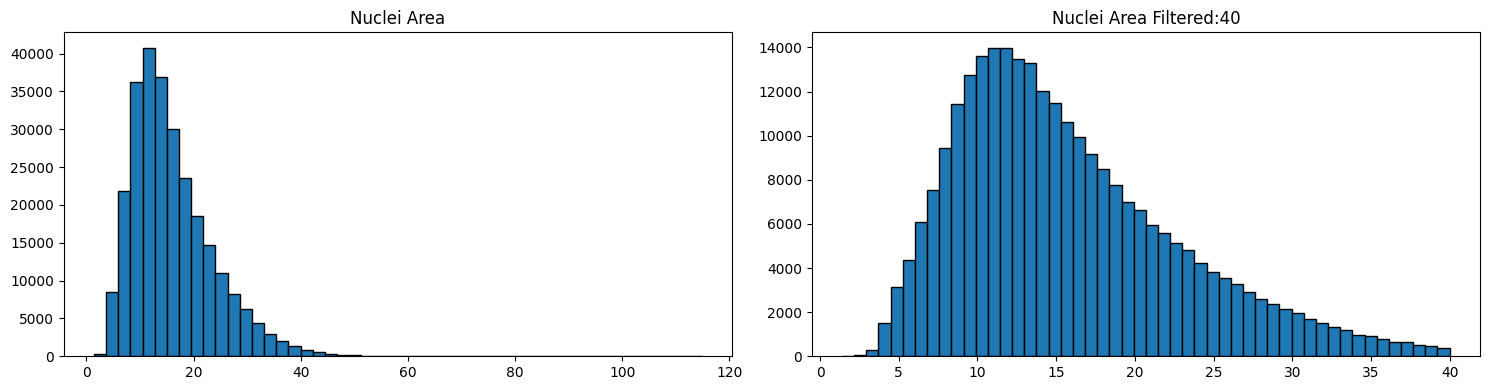

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
plot_nuclei_area(gdf = geo_file, area_cut_off=40)

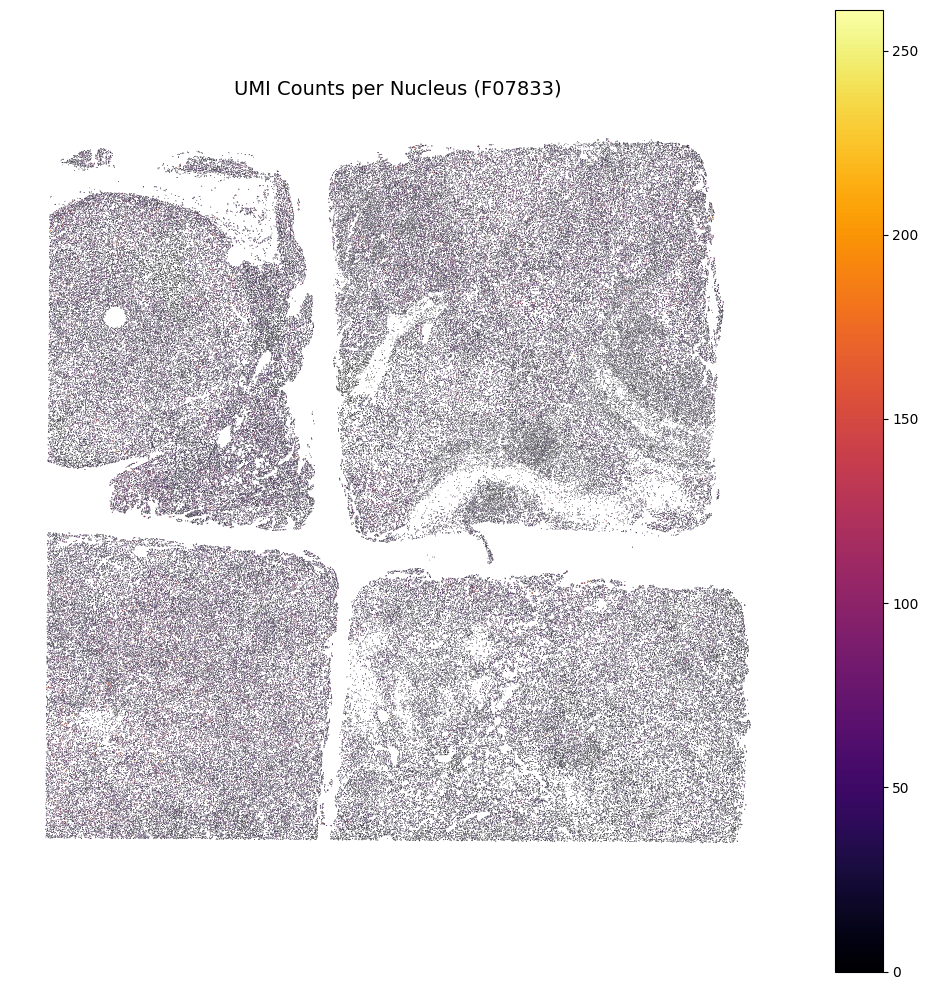

In [30]:
import matplotlib.pyplot as plt

# 1. Compute total UMI counts per nucleus from the AnnData object
total_umis = adata.X.sum(axis=1).A1  # flatten sparse matrix
adata.obs['total_umis'] = total_umis

# 2. Merge with geometry data from GeoPackage
gdf_umi = geo_file.merge(adata.obs[['total_umis']], left_on='id', right_index=True)

# 3. Plot polygons colored by total UMI count
fig, ax = plt.subplots(figsize=(10, 10))
gdf_umi.plot(column='total_umis',
             cmap='inferno',
             legend=True,
             linewidth=0.1,
             edgecolor='black',
             ax=ax)

ax.set_title("UMI Counts per Nucleus (F07833)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [32]:
import matplotlib.pyplot as plt
import os

# Define output path
output_dir = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures")
output_file = output_dir / "F07833_umi_per_nucleus.png"

# Ensure directory exists
output_dir.mkdir(parents=True, exist_ok=True)

# Plot and save
fig, ax = plt.subplots(figsize=(10, 10))
gdf_umi.plot(column='total_umis',
             cmap='inferno',
             legend=True,
             linewidth=0.1,
             edgecolor='black',
             ax=ax)

ax.set_title("UMI Counts per Nucleus (F07833)", fontsize=14)
ax.axis('off')
plt.tight_layout()

# Save high-resolution image
plt.savefig(output_file, dpi=600, bbox_inches='tight')
plt.close()

print(f"UMI heatmap saved to:\n{output_file}")


UMI heatmap saved to:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/F07833_umi_per_nucleus.png


In [34]:
# Filter GeoDataFrame for nuclei with 100 or more UMIs
gdf_umi_filtered = gdf_umi[gdf_umi['total_umis'] >= 50]

# Define output path
filtered_output_file = output_dir / "F07833_umi_per_nucleus_filtered_50.png"

# Plot and save
fig, ax = plt.subplots(figsize=(10, 10))
gdf_umi_filtered.plot(column='total_umis',
                      cmap='inferno',
                      legend=True,
                      linewidth=0.1,
                      edgecolor='black',
                      ax=ax)

ax.set_title("Nuclei with ≥70 UMIs (F07833)", fontsize=14)
ax.axis('off')
plt.tight_layout()

# Save high-resolution image
plt.savefig(filtered_output_file, dpi=600, bbox_inches='tight')
plt.close()

print(f"Filtered UMI heatmap saved to:\n{filtered_output_file}")


Filtered UMI heatmap saved to:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/F07833_umi_per_nucleus_filtered_50.png


In [23]:
# Adjust the prefix as needed depending on your organism (MT- for human, mt- for mouse)
mito_genes = adata.var_names.str.startswith('MT-')
# Sum the counts of mitochondrial genes for each cell
adata.obs['mito_counts'] = adata[:, mito_genes].X.sum(axis=1).A1  # .A1 to flatten sparse matrix
adata.obs['total_counts'] = adata.X.sum(axis=1).A1
adata.obs['percent_mito'] = 100 * adata.obs['mito_counts'] / adata.obs['total_counts']

adata_filtered = adata[
    (adata.obs['total_counts'] >= 70) &
    (adata.obs['percent_mito'] <= 15)
].copy()


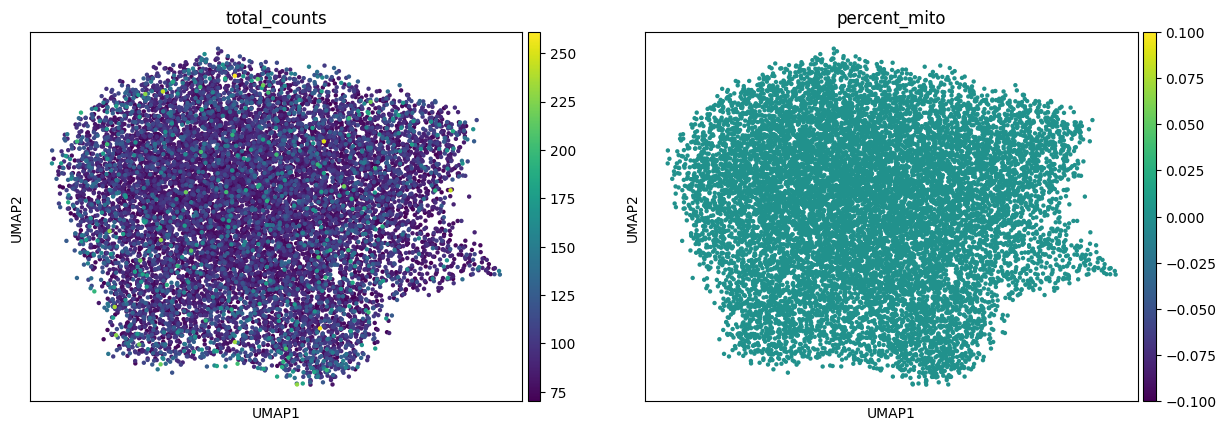

In [24]:
import scanpy as sc

# Start with a copy to preserve your original data
adata_qc = adata_filtered.copy()

# Step 1: Just log-transform raw counts (NO normalize_total)
sc.pp.log1p(adata_qc)

# Step 2: Identify highly variable genes
sc.pp.highly_variable_genes(adata_qc, n_top_genes=2000, subset=True)

# Step 3: Scale (optional but useful for PCA-based neighborhood graph)
sc.pp.scale(adata_qc, max_value=10)

# Step 4: PCA
sc.tl.pca(adata_qc, svd_solver='arpack')

# Step 5: Neighbors and embedding
sc.pp.neighbors(adata_qc, n_neighbors=8, n_pcs=30)  # Or 10, 20
sc.tl.umap(adata_qc)

# Step 6: UMAP visualization
sc.pl.umap(adata_qc, color=['total_counts', 'percent_mito'], size=40)


In [40]:
import matplotlib.pyplot as plt
from pathlib import Path

# Define the path to save the figure
fig_output = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/")
fig_output.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Plot and save the UMAP
sc.pl.umap(
    adata_qc,
    color=['total_counts', 'percent_mito'],
    size=40,
    show=False  # Prevent display in Jupyter if running there
)

# Save the figure
umap_path = fig_output / "F07833_umap_total_counts_percent_mito.png"
plt.savefig(umap_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"UMAP figure saved at:\n{umap_path}")

UMAP figure saved at:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/F07833_umap_total_counts_percent_mito.png


In [27]:
# Step 1: Run Leiden clustering (you can adjust resolution)
sc.tl.leiden(adata_qc, resolution=0.6)  # Try 0.3–1.0 depending on how fine-grained you want

# Step 2: Plot UMAP with clusters
sc.pl.umap(
    adata_qc,
    color='leiden',
    size=40,
    legend_loc='on data',
    show=False  # To save instead of display
)

# Step 3: Save the figure
cluster_umap_path = fig_output / "F07833_umap_leiden_clusters.png"
plt.savefig(cluster_umap_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Clustered UMAP figure saved at:\n{cluster_umap_path}")


Clustered UMAP figure saved at:
/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures/F07833_umap_leiden_clusters.png
